In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from PIL import Image
!pip install torchsummary
import random
from torchsummary import summary
import zipfile
import shutil
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [2]:
# remove all files
if os.path.exists(os.path.join("./data")):
    shutil.rmtree("./data")

In [3]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [4]:
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z: 
    z.extractall("data/")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", "r") as z:
    z.extractall('data/')

In [5]:
train_dir = "./data/train"
print(f"Training images: {len(os.listdir(train_dir))}")

Training images: 25000


In [6]:
# reorganizing file structure

for file in os.listdir(train_dir):                
    if file.startswith("cat"):
        if not os.path.exists(os.path.join(train_dir, "cat")):
            os.mkdir(os.path.join(train_dir, "cat"))
        src_path = os.path.join(train_dir, file) 
        dst_path = os.path.join(os.path.join(train_dir, "cat"), file) 
        shutil.move(src_path, dst_path)
            
    else:
        if not os.path.exists(os.path.join(train_dir, "dog")):
                os.mkdir(os.path.join(train_dir, "dog"))
        src_path = os.path.join(train_dir, file) 
        dst_path = os.path.join(os.path.join(train_dir, "dog"), file) 
        shutil.move(src_path, dst_path)
        
# generating a validation set with 20% of images

for cl in ['cat' , 'dog']:
    files = os.listdir(os.path.join(train_dir, cl))
    random.seed(12345)
    random.shuffle(files)
    size = int(len(files)*0.2)
    selected_files = [files[n] for n in range(size)]
    for file in selected_files:
        
        src_path = os.path.join(train_dir, cl, file)
        
        if not os.path.exists(os.path.join("./data",'valid')):
            os.mkdir(os.path.join("./data/valid"))
        
        if not os.path.exists(os.path.join("./data",'valid', cl)):
            os.mkdir(os.path.join("./data/valid",cl))
        
        dst_path = os.path.join("./data/valid/", cl, file)
        shutil.move(src_path, dst_path)

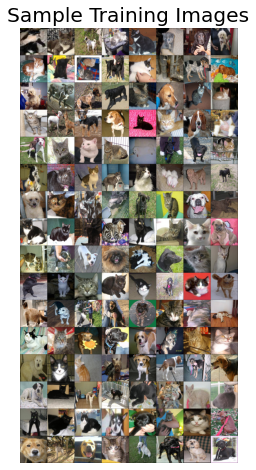

In [23]:
train_dir = "./data/train"
valid_dir = "./data/valid"


image_size = 250
batch_size = 128

data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    #transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valid_dir, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

In [8]:
print('Training data')
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))

Training data
Classes: ['cat', 'dog']
Class count: 10000, 10000
Samples: 20000


In [9]:
print('Training data')
print(f"Classes: {valid_dataset.classes}")
print(f"Class count: {valid_dataset.targets.count(0)}, {valid_dataset.targets.count(1)}")
print(f"Samples:",len(valid_dataset))

Training data
Classes: ['cat', 'dog']
Class count: 2500, 2500
Samples: 5000


In [10]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    
    
    print('Training started:\n')
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    
    for epoch in range(epochs):  
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)  
            optimizer.zero_grad()                 
            y_hat = model(X).flatten()           
            loss = criterion(y_hat, y.type(torch.float32))  
            loss.backward()             
            optimizer.step()            
            train_batch_loss += loss.item()  
        train_loss.append(train_batch_loss / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

In [29]:
class cats_dogs_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(3200, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [30]:
model = cats_dogs_CNN()
model.to(device)
summary(model,(3 ,250, 250));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 248, 248]             896
              ReLU-2         [-1, 32, 248, 248]               0
         MaxPool2d-3         [-1, 32, 124, 124]               0
            Conv2d-4         [-1, 64, 122, 122]          18,496
              ReLU-5         [-1, 64, 122, 122]               0
         MaxPool2d-6           [-1, 64, 61, 61]               0
           Dropout-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 59, 59]          36,928
              ReLU-9           [-1, 64, 59, 59]               0
        MaxPool2d-10           [-1, 64, 29, 29]               0
           Conv2d-11          [-1, 128, 27, 27]          73,856
             ReLU-12          [-1, 128, 27, 27]               0
        MaxPool2d-13          [-1, 128, 13, 13]               0
          Dropout-14          [-1, 128,

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
results = trainer(model, criterion, optimizer, train_loader, valid_loader,device, epochs=10)

## Transfer Learning

In [ ]:
densenet = models.densenet121(pretrained=True)
densenet.eval();

for param in densenet.parameters():
    param.requires_grad = False

In [ ]:
new_layers = nn.Sequential(
    nn.Linear(1024, 800),
    nn.ReLU(),
    nn.Linear(800, 500),
    nn.ReLU(),
    nn.Linear(500, 6)
)
densenet.classifier = new_layers

In [ ]:
densenet.to(device)
optimizer = optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=10)